# Project: Identify Customer Segments

<p2> In this project, I applied supervised learning techniques to identify segments of the population that formed a customer base for a mail order sales company in Germany. After data collection, these segments can be used to direct marketing campaigns. The data has been provided by Bertelsmann Avato Analytics.

## Libraries Used
Numpy

Pandas

Matplotlib

Seaborn

KMeans/MiniBatchKMeans

StandardScaler

PCA

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [7]:
#load general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=";")

#load feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=";")

In [8]:
#check structure of files
az_rows, az_columns = azdias.shape
fi_rows, fi_columns = feat_info.shape

print('Number of rows in general demographic dataset: {}'.format(az_rows))
print('Number of columns in general demographic dataset: {}'.format(az_columns))

print('Number of rows in feature summary: {}'.format(fi_rows))
print('Number of columns in feature summary: {}'.format(fi_columns))

Number of rows in general demographic dataset: 891221
Number of columns in general demographic dataset: 85
Number of rows in feature summary: 85
Number of columns in feature summary: 4


In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Preprocessing

### Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I use this file to help make cleaning decisions during this stage of the project. 

#### Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. 

In [11]:
#identify missing or unknown data values and convert them to NaNs.

for attribute in feat_info['attribute']:

    tmp_list = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
    missing_or_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in tmp_list]

    
    azdias[attribute].replace(to_replace=missing_or_unknown_list,
                      value=np.nan, inplace=True)

#### Assess Missing Data in Each Column

In [12]:
#find how much missing data there is in each column of azdias dataset

azdias.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [13]:
#save null values to a fd
missing_per = azdias.isnull().sum()

#get percentage
missing_per = missing_per[missing_per > 0]/(azdias.shape[0]) * 100

#sort
missing_per.sort_values(inplace=True)

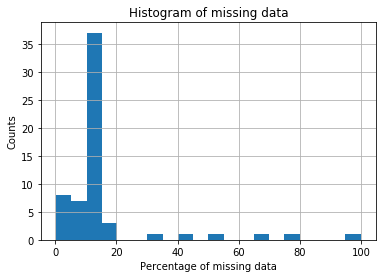

In [14]:
#create plot of the percentage of missing values

plt.hist(missing_per, bins=20)
plt.xlabel('Percentage of missing data')
plt.ylabel('Counts')
plt.title('Histogram of missing data')
plt.grid(True)
plt.show()

In [15]:
missing_per

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

In [16]:
#assign columns with > 20% of data missing to a df
outlier_columns = missing_per[missing_per > 20].index

In [17]:
outlier_columns

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

In [18]:
#remove outlier columns
az_clean = azdias.drop(columns=outlier_columns)
az_clean.shape

(891221, 79)

I removed 6 columns that had 30% or more of the data missing. The columns that stood as outliers where:

-GEBAEUDETYP'

-'ALTER_HH'

-'KK_KUNDENTYP'

-'KBA05_BAUMAX'

-'TITEL_KZ'

-'AGER_TYP'

#### Assess Missing Data in Each Row

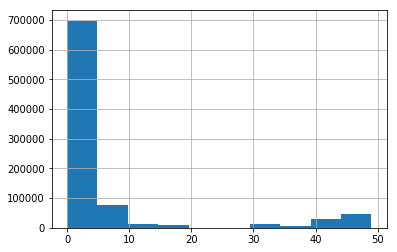

In [19]:
#plot histogram to see how much data missing in rows

az_clean.isnull().sum(axis=1).sort_values(ascending=False).hist()

In [20]:
#divide the data into two subsets based on the number of missing values in each row.

missing_rows = az_clean.isnull().sum(axis=1) / len(az_clean.columns) * 100

threshold = 25

rows_above_threshold = az_clean[missing_rows < threshold]
rows_below_threshold = az_clean[missing_rows >= threshold]

In [21]:
#compare the distribution of values for five columns where there are
#no or few missing values, between the two subsets.

def compare_distribution(column_name):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=rows_above_threshold)
    plt.title('{} Distribution - Rows with many missing values'.format(column_name))
    
    plt.subplot(1,2,2)
    sns.countplot(x=column_name, data=rows_below_threshold)
    plt.title('{} Distribution - Rows with few missing values'.format(column_name))
    
    plt.tight_layout()
    plt.show()

In [22]:
rows_below_threshold.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [23]:
rows_above_threshold.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

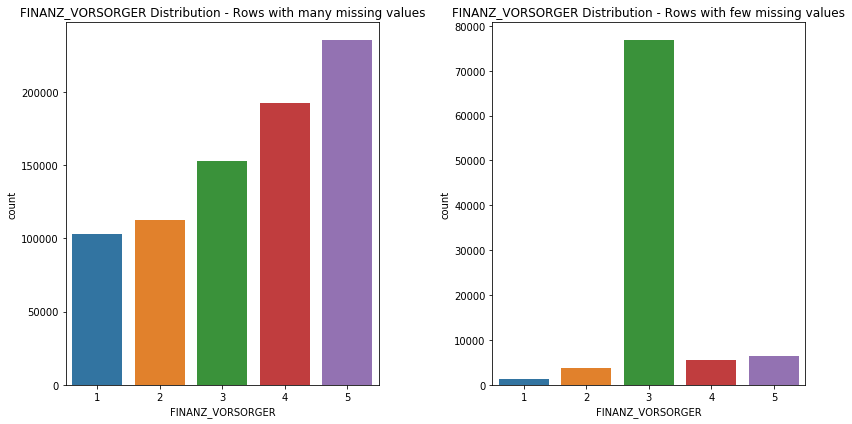

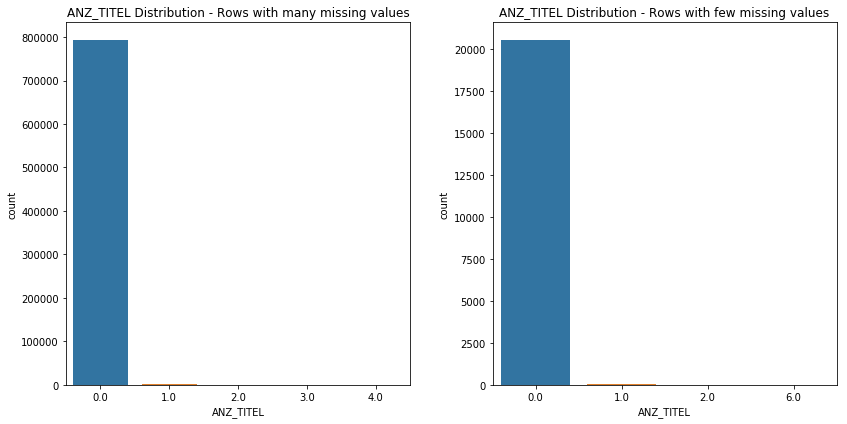

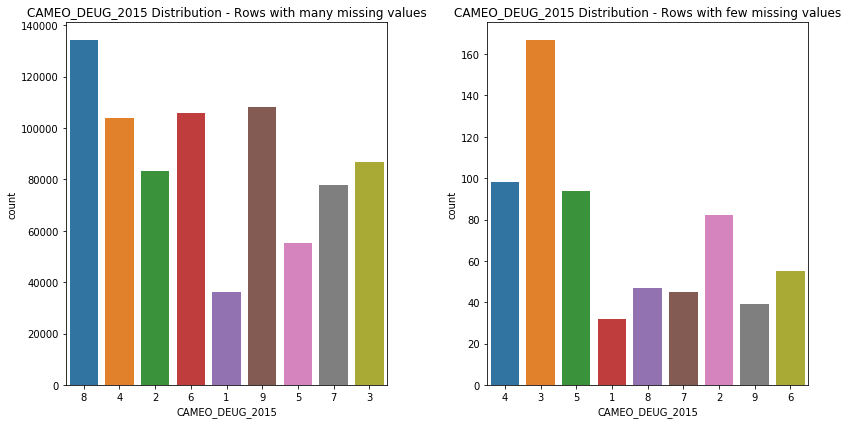

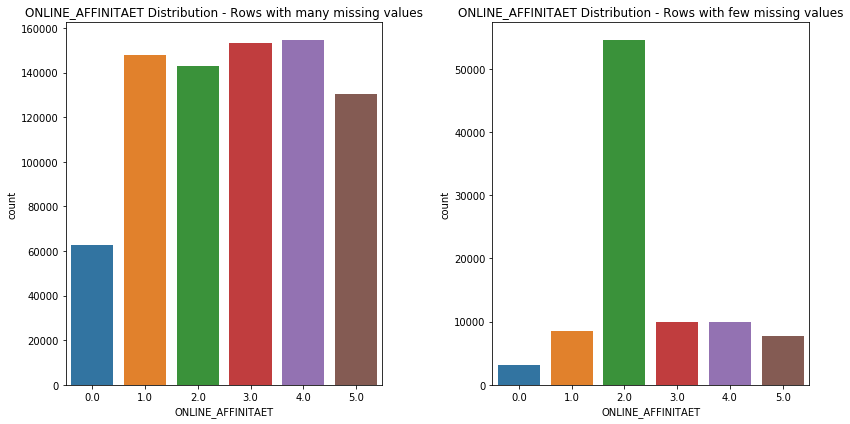

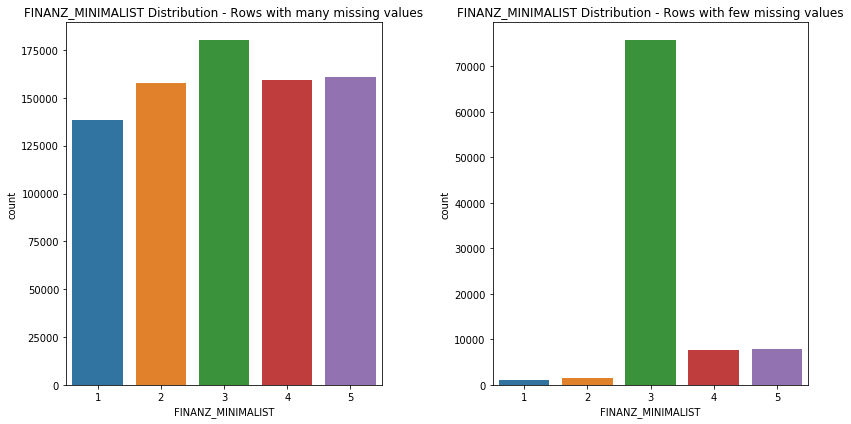

In [24]:
compare_distribution('FINANZ_VORSORGER')
compare_distribution('ANZ_TITEL')
compare_distribution('CAMEO_DEUG_2015')
compare_distribution('ONLINE_AFFINITAET')
compare_distribution('FINANZ_MINIMALIST')

### Select and Re-Encode Features

In [25]:
#find how many features there are of each data type?

feat_info.groupby(by='type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


### Re-Encode Categorical Features

In [26]:
#assess categorical variables
for attribute in feat_info[feat_info['type']=='categorical'].attribute:
    if attribute in az_clean.columns:
        print(attribute, az_clean[attribute].nunique())


ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 2
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
SOHO_KZ 2
VERS_TYP 2
ZABEOTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44


In [27]:
# access binary level categorical variables
for attribute in feat_info[feat_info['type']=='categorical'].attribute:
    if attribute in az_clean.columns:
        if az_clean[attribute].nunique() == 2:
            print(attribute, az_clean[attribute].unique())

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [nan  1.  0.]
VERS_TYP [nan  2.  1.]
OST_WEST_KZ [nan 'W' 'O']


In [28]:
#re-encode categorical variable 'OST_WEST_KZ'

az_clean = pd.get_dummies(data=az_clean, columns=['OST_WEST_KZ'])

In [29]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [30]:
#access multi level variables
multi_level_vars = []

for col in az_clean.columns:
    if col in feat_info['attribute'].values:
        if feat_info.loc[feat_info['attribute'] == col, 'type'].values[0] == 'categorical':
            if len(az_clean[col].unique()) > 2:
                multi_level_vars.append(col)
                
multi_level_vars

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [31]:
#remove columns with 2 or more variables
for col in multi_level_vars:
    az_clean.drop(col, axis=1, inplace=True)

In [32]:
az_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_AN

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; :
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


I am referencing `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
#read in data dictionary file
with open("Data_Dictionary.md", "r") as file:
    data_dict = file.read()

In [34]:
#investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

if 'PRAEGENDE_JUGENDJAHRE' in az_clean.columns:
    #extract decade (tens place) and movement (ones place)
    az_clean['PRAEGENDE_DECADE'] = az_clean['PRAEGENDE_JUGENDJAHRE'] // 10  #decade -numeric
    az_clean['PRAEGENDE_MOVEMENT'] = az_clean['PRAEGENDE_JUGENDJAHRE'] % 10  #movement -binary-
    az_clean['PRAEGENDE_MOVEMENT'] = az_clean['PRAEGENDE_MOVEMENT'].apply(lambda x: 1 if x == 1 else 0)  #binary encoding

In [35]:
#investigate "CAMEO_INTL_2015" and engineer two new variables.

if 'CAMEO_INTL_2015' in az_clean.columns:
    def extract_tens_place(x):
        try:
            return int(str(x)[0])  #extract tens place as an integer
        except (ValueError, TypeError):
            return None 

    def extract_ones_place(x):
        try:
            return int(str(x)[1])  #extract ones place as an integer
        except (ValueError, TypeError):
            return None  

    # Apply extraction functions
    az_clean['CAMEO_WEALTH'] = az_clean['CAMEO_INTL_2015'].apply(extract_tens_place)
    az_clean['CAMEO_LIFESTAGE'] = az_clean['CAMEO_INTL_2015'].apply(extract_ones_place)

In [36]:
az_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT,CAMEO_WEALTH,CAMEO_LIFESTAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,15.0,4.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,1.0,0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,1.0,0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0.0,0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,0.0,0,4.0,3.0


#### Discussion: Engineer Mixed-Type Features

I engineered 'PRAEGENDE_JUGENDJAHRE' (PJ) and 'CAMEO_INTL_2015' (CI) columns. From PJ, two new fearures were created, decade and movement, indicating whether an individual identified with mainstream or avantgarde movements. For CI, I extracted 2 ordinal cariables, Wealth and life stage which both represent economic status.

### Complete Feature Selection

In order to finish this step up, I need to make sure that my data frame now only has the columns that I want to keep. After this step the dataframe willconsist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [37]:
az_clean.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
ANZ_PERSONEN             float64
ANZ_TITEL                float64
HH_EINKOMM

In [38]:
#drop 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' from dataset

az_clean.drop(columns=['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], inplace=True)

In [39]:
az_clean.shape

(891221, 67)

In [40]:
#fill missing values with interpolation
for col in az_clean.columns:
    az_clean[col] = az_clean[col].interpolate(limit_direction='both')

In [41]:
az_clean.isnull().sum().sum()

0

### Create a Cleaning Function

In [42]:
def clean_data(df):
  
    
    # convert missing value codes into NaNs, ...
    for attribute in feat_info['attribute']:

        tmp_list = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
        missing_or_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in tmp_list]

    
        azdias[attribute].replace(to_replace=missing_or_unknown_list,
                      value=np.nan, inplace=True)
    
    # remove selected columns and rows
    columns_removed = ['ALTER_HH', 'GEBURTSJAHR', 'CJT_GESAMTTYP', 'KBA05_BAUMAX', 
                       'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ' 
                       'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
                       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 
                       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 
                       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
                       
    for col in columns_removed:
        if col in df:
            df.drop(col, axis=1, inplace=True)
        
    missing_rows = df[df.isnull().sum(axis=1) < 10].reset_index(drop=True)
    
        
    #recode categorical varuable
    df.loc[:, 'OST_WEST_KZ'].replace({'W':'0', 'O':'1'}, inplace=True)
    df['OST_WEST_KZ'].fillna(df['OST_WEST_KZ'].mode()[0], inplace=True)
      
    
    # select, re-encode, and engineer column values.
    if 'PRAEGENDE_JUGENDJAHRE' in df:
        #extract decade (tens place) and movement (ones place)
        df['PRAEGENDE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'] // 10  #decade -numeric
        df['PRAEGENDE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'] % 10  #movement -binary
        df['PRAEGENDE_MOVEMENT'] = df['PRAEGENDE_MOVEMENT'].apply(lambda x: 1 if x == 1 else 0)  #binary encoding
        df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)   
  
    if 'CAMEO_INTL_2015' in df.columns:
        def extract_tens_place(x):
            try:
                return int(str(x)[0])  #extract tens place as an integer
            except (ValueError, TypeError):
                return None 

        def extract_ones_place(x):
            try:
                return int(str(x)[1])  #extract ones place as an integer
            except (ValueError, TypeError):
                return None  

        # Apply extraction functions
        df['CAMEO_WEALTH'] = df['CAMEO_INTL_2015'].apply(extract_tens_place)
        df['CAMEO_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(extract_ones_place)
        df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
     #interplate/impute nans
    for col in df.columns:
        df[col] = df[col].interpolate(limit_direction='both')
    
    # Return the cleaned dataframe.
    return df
    
    

## Feature Transformation

### Apply Feature Scaling

In [44]:
#apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

#initialize the StandardScaler
scaler = StandardScaler()

#fit scaler and transform data
az_scale = pd.DataFrame(scaler.fit_transform(az_clean), columns=az_clean.columns)

### Perform Dimensionality Reduction

In [45]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
az_pca = pca.fit_transform(az_scale)

In [46]:
#investigate the variance accounted for by each principal component.

variance_explained = pca.explained_variance_ratio_
cumulative_variance = variance_explained.cumsum()

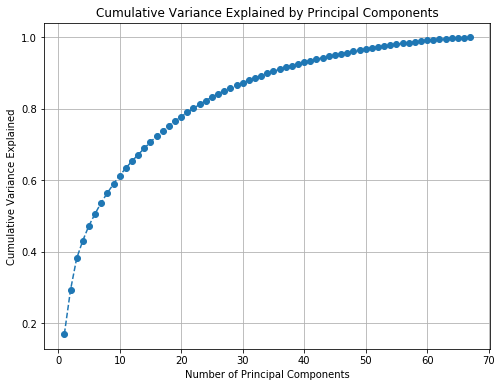

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

In [75]:
#re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=20)
az_pca = pca.fit_transform(az_scale)

### Discussion: Perform Dimensionality Reduction

I used 20 principal components because that is where the graph breaks.

### Interpret Principal Components

In [76]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

feature_select = pd.DataFrame(pca.components_,columns=az_scale.columns).T
feature_select[0].sort_values()

MOBI_REGIO              -0.239091
PLZ8_ANTG1              -0.230275
KBA05_ANTG1             -0.221520
KBA05_GBZ               -0.215474
FINANZ_MINIMALIST       -0.192149
PLZ8_GBZ                -0.172021
INNENSTADT              -0.170942
KONSUMNAEHE             -0.170017
LP_LEBENSPHASE_FEIN     -0.139116
BALLRAUM                -0.132693
LP_LEBENSPHASE_GROB     -0.125423
GEBAEUDETYP_RASTER      -0.120696
CAMEO_LIFESTAGE         -0.117302
ANZ_PERSONEN            -0.092538
GREEN_AVANTGARDE        -0.092229
WOHNLAGE                -0.091640
FINANZ_VORSORGER        -0.081737
KBA13_ANZAHL_PKW        -0.081077
ALTERSKATEGORIE_GROB    -0.080041
ONLINE_AFFINITAET       -0.063290
OST_WEST_KZ_W           -0.055695
MIN_GEBAEUDEJAHR        -0.053843
WOHNDAUER_2008          -0.050339
SEMIO_ERL               -0.050071
SEMIO_LUST              -0.043586
SEMIO_VERT              -0.041708
PRAEGENDE_MOVEMENT      -0.030777
ANZ_TITEL               -0.002242
RETOURTYP_BK_S           0.000982
KBA05_ANTG2   

In [77]:
#map weights for the second principal component to corresponding feature names
#and then print the linked values, sorted by weight.

feature_select[1].sort_values()

FINANZ_SPARER           -0.269921
SEMIO_REL               -0.264147
SEMIO_PFLICHT           -0.255610
PRAEGENDE_DECADE        -0.250511
FINANZ_UNAUFFAELLIGER   -0.244495
SEMIO_TRADV             -0.242395
FINANZ_ANLEGER          -0.232659
SEMIO_RAT               -0.203407
SEMIO_KULT              -0.194705
SEMIO_FAM               -0.183889
SEMIO_MAT               -0.178275
ONLINE_AFFINITAET       -0.152658
SEMIO_SOZ               -0.063526
HEALTH_TYP              -0.061007
PLZ8_ANTG1              -0.059323
KBA05_GBZ               -0.055420
MOBI_REGIO              -0.052806
INNENSTADT              -0.052123
ANZ_PERSONEN            -0.049718
PLZ8_GBZ                -0.049078
KONSUMNAEHE             -0.045620
KBA05_ANTG1             -0.044917
BALLRAUM                -0.043129
WOHNLAGE                -0.042038
MIN_GEBAEUDEJAHR        -0.041957
GEBAEUDETYP_RASTER      -0.028483
LP_LEBENSPHASE_GROB     -0.027008
KBA13_ANZAHL_PKW        -0.025942
LP_LEBENSPHASE_FEIN     -0.018997
KBA05_ANTG2   

In [78]:
#map weights for the third principal component to corresponding feature names
#and then print the linked values, sorted by weight.

feature_select[2].sort_values()

ANREDE_KZ               -0.362257
SEMIO_KAEM              -0.362028
SEMIO_DOM               -0.334212
SEMIO_KRIT              -0.308976
SEMIO_RAT               -0.183261
SEMIO_ERL               -0.179536
FINANZ_ANLEGER          -0.175652
FINANZ_UNAUFFAELLIGER   -0.098841
FINANZ_SPARER           -0.085251
FINANZ_HAUSBAUER        -0.058328
SEMIO_PFLICHT           -0.050140
PRAEGENDE_DECADE        -0.049812
PLZ8_ANTG1              -0.031021
PLZ8_GBZ                -0.027821
INNENSTADT              -0.026282
SEMIO_TRADV             -0.024197
KONSUMNAEHE             -0.022707
GEBAEUDETYP_RASTER      -0.021464
BALLRAUM                -0.020445
KBA13_ANZAHL_PKW        -0.018114
MOBI_REGIO              -0.016172
HEALTH_TYP              -0.014576
ONLINE_AFFINITAET       -0.014399
KBA05_GBZ               -0.013195
KBA05_ANTG1             -0.012542
CAMEO_LIFESTAGE         -0.011612
MIN_GEBAEUDEJAHR        -0.009306
KBA05_ANTG2             -0.008633
KKK                     -0.007546
WOHNLAGE      

## Clustering

### Apply Clustering to General Population

In [82]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

#create kmeans function
def get_kmeans_score(data, center):
    #initialize MiniBatchKMeans to reduce time
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=42, batch_size=1024)
    kmeans.fit(data)
    #use inertia to find sum of squared distances
    score = kmeans.inertia_
    return score

In [83]:
# Investigate the change in within-cluster distance across number of clusters.

import time


start_time = time.time()

#create list of centers
centers = list(range(1, 31, 2))

#compute KMeans score
score = [get_kmeans_score(az_pca, center) for center in centers]

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 2.52 mins ---


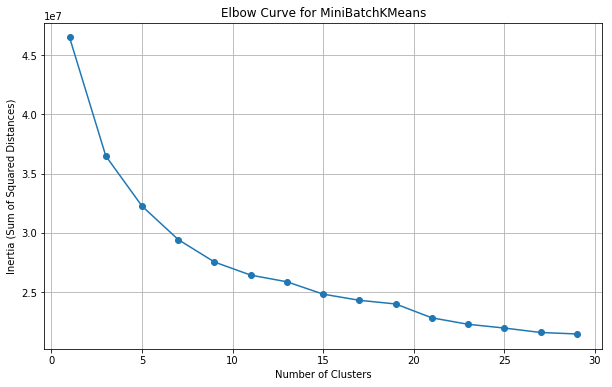

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(centers, score, marker='o')
plt.title("Elbow Curve for MiniBatchKMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid()
plt.show()

In [85]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions

kmeans = MiniBatchKMeans(n_clusters=13, random_state=42, batch_size=1024)
model = kmeans.fit_predict(az_pca)

### Discussion: Apply Clustering to General Population

I used MiniBatchKMeans to get Kmeans score to speed up the process while testing cluster counts from 1 to 30. The elbow indicated a break at 13 clusters so I finalized the model with n_clusters = 13.

### Apply All Steps to the Customer Data

In [86]:
#load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [57]:
customers.head(1)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0


In [87]:
#clean the data
customers_clean = clean_data(customers)

In [88]:
customers_clean.isnull().sum().sum()

0

In [89]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean_fit = pd.DataFrame(scaler.fit_transform(customers_clean))
customers_clean_fit.columns = customers_clean.columns

In [90]:
customers_pca = pca.fit_transform(customers_clean_fit)

In [91]:
k_customer = kmeans.fit_predict(customers_pca)

### Compare Customer Data to Demographics Data

In [92]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
result_customer = pd.Series(k_customer)
customer_dist = result_customer.value_counts().sort_index()
result = pd.Series(model)
population_dist = result.value_counts().sort_index()
final_df = pd.DataFrame([population_dist,customer_dist]).T
final_df.columns = ['population_count','customer_count']
final_df

,population_count,customer_count
0,62371,17296
1,99886,12675
2,64676,9988
3,45954,11576
4,83824,7321
5,75982,10206
6,58320,16892
7,57197,2191
8,54170,22178
9,71224,30472


In [108]:
#calculate proportions
final_df['population_proportion'] = final_df['population_count'] / final_df['population_count'].sum()
final_df['customer_proportion'] = final_df['customer_count'] / final_df['customer_count'].sum()

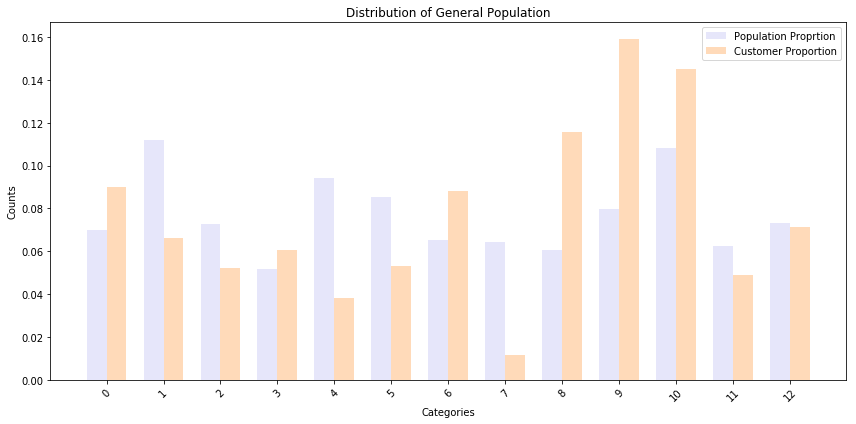

In [115]:
plt.figure(figsize=(12, 6))
x = np.arange(len(final_df.index)) 
bar_width = 0.35
plt.bar(x - bar_width/2, final_df['population_proportion'], bar_width, label='Population Proprtion', color='lavender')
plt.bar(x + bar_width/2, final_df['customer_proportion'], bar_width, label='Customer Proportion', color='#FFDAB9')
plt.title("Distribution of General Population")
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.xticks(x, final_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [126]:
#evaluate What kinds of people are part of a cluster that is overrepresented in the
#customer data compared to the general population? (Analysis in Discussion)
feature_select[8].sort_values()

REGIOTYP                -0.386375
KKK                     -0.349627
SEMIO_REL               -0.203968
PLZ8_HHZ                -0.169218
SEMIO_FAM               -0.165218
SEMIO_KRIT              -0.145334
FINANZ_UNAUFFAELLIGER   -0.142126
ORTSGR_KLS9             -0.137396
SEMIO_LUST              -0.134527
KBA13_ANZAHL_PKW        -0.134431
FINANZ_MINIMALIST       -0.133273
KBA05_ANTG4             -0.132635
PLZ8_GBZ                -0.124718
FINANZ_ANLEGER          -0.121731
RETOURTYP_BK_S          -0.119253
KBA05_ANTG1             -0.115790
EWDICHTE                -0.114869
W_KEIT_KIND_HH          -0.109163
ARBEIT                  -0.098764
WOHNDAUER_2008          -0.092745
ANZ_HAUSHALTE_AKTIV     -0.084865
PLZ8_ANTG1              -0.077567
GEBAEUDETYP_RASTER      -0.064395
SEMIO_KAEM              -0.059824
SEMIO_PFLICHT           -0.056169
RELAT_AB                -0.054172
MOBI_REGIO              -0.054075
FINANZ_VORSORGER        -0.038044
FINANZ_SPARER           -0.034766
HEALTH_TYP    

In [118]:
cat8 = kmeans.cluster_centers_[8]
cat8 = pd.Series(cat8)
cat8.sort_values(ascending=False, inplace=True)
cat8.head()

0     3.692469
7     0.229197
11    0.159025
12   -0.044294
6    -0.049362
dtype: float64

In [119]:
#evaluate what kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population? (Analysis in Discussion)

feature_select[7].sort_values()

OST_WEST_KZ_O           -0.314384
PLZ8_HHZ                -0.286300
KBA13_ANZAHL_PKW        -0.249634
KBA05_ANTG2             -0.231951
KBA05_ANTG3             -0.207276
PLZ8_GBZ                -0.180369
ARBEIT                  -0.171472
PLZ8_ANTG2              -0.162459
PLZ8_ANTG3              -0.157865
BALLRAUM                -0.106119
SEMIO_MAT               -0.105531
SEMIO_LUST              -0.103082
FINANZ_ANLEGER          -0.098304
SEMIO_FAM               -0.092911
FINANZ_HAUSBAUER        -0.086840
LP_LEBENSPHASE_FEIN     -0.072510
LP_LEBENSPHASE_GROB     -0.070085
MIN_GEBAEUDEJAHR        -0.069949
SEMIO_REL               -0.062040
INNENSTADT              -0.060440
KBA05_GBZ               -0.059285
GEBAEUDETYP_RASTER      -0.055143
ALTERSKATEGORIE_GROB    -0.049769
ANZ_PERSONEN            -0.048160
CAMEO_LIFESTAGE         -0.042532
WOHNDAUER_2008          -0.039305
PLZ8_ANTG4              -0.036653
CAMEO_WEALTH            -0.030461
SEMIO_KRIT              -0.030321
FINANZ_MINIMAL

In [125]:
cat7 = kmeans.cluster_centers_[7]
cat7 = pd.Series(cat7)
cat7.sort_values(ascending=False, inplace=True)
cat7.head()

9    8.212681
6    3.693405
7    3.084466
2    1.337095
5    1.119679
dtype: float64

### Discussion: Compare Customer Data to Demographics Data

Over-Represented - An overrepresented group in the customer data shows in cluster 8. This cluster of people are made up of people that live in West Germany aand mainly high income or urban areas.

Under-Represented - An unrepresented group in the customer data come from cluster group 7 and live in East Germany in areas with older buildings and smaller households